# Medical Cost Prediction 

#### Installing Libraries and analyzing data

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score

In [3]:
df= pd.read_csv(r"C:\Users\HP\Downloads\insurance (1).csv")

In [4]:
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.shape

(1338, 7)

In [4]:
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.children.value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

In [7]:
df.region.value_counts()


region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [6]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [7]:
df.drop(df.index[581],inplace=True)

In [8]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges


#### Performing EDA 

In [9]:
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
677,60,male,31.35,3,yes,northwest,46130.5265
835,42,male,35.97,2,no,southeast,7160.3303
304,57,female,38.00,2,no,southwest,12646.2070
826,56,male,31.79,2,yes,southeast,43813.8661
197,45,female,28.60,2,no,southeast,8516.8290


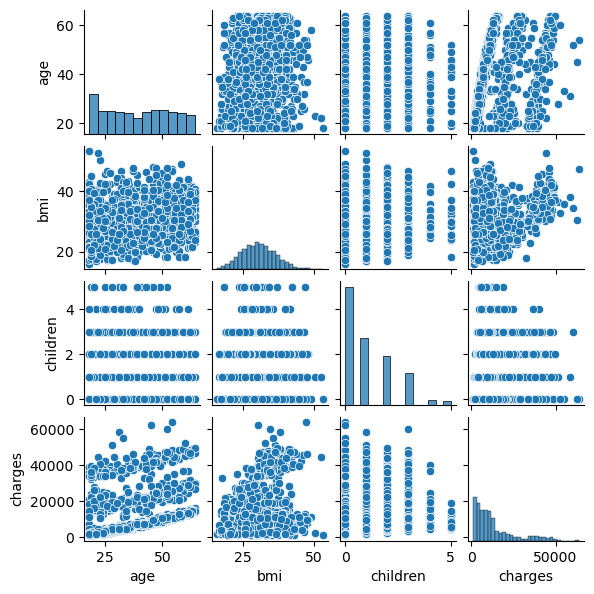

In [9]:
sns.pairplot(df, height=1.5) 
plt.show()


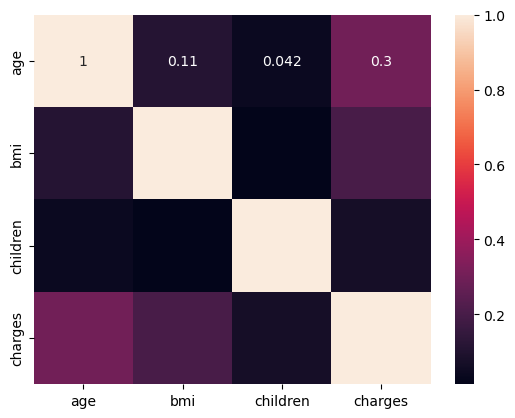

In [97]:
num_cols=df[['age','bmi','children','charges']]
sns.heatmap(num_cols.corr(), annot=True)
plt.show()




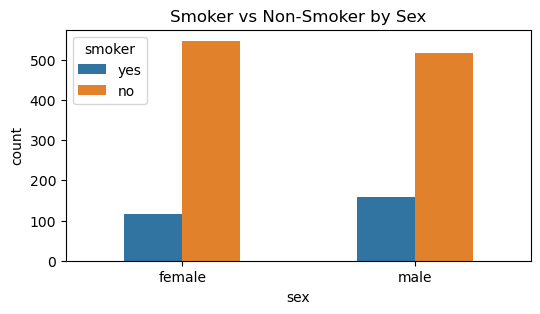

In [10]:
plt.figure(figsize=(6,3))
sns.countplot(data=df, x='sex', hue='smoker',width=0.5)
plt.title('Smoker vs Non-Smoker by Sex')
plt.show()

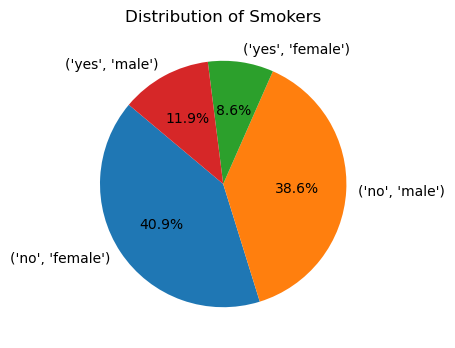

In [11]:
#counts = df['smoker'].value_counts()
counts = df.groupby(['smoker', 'sex']).size()
plt.figure(figsize=(6, 4))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Smokers')
plt.show()


Text(0.5, 1.0, 'Age Frequency')

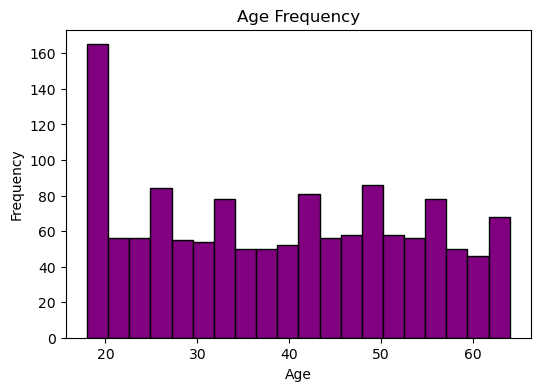

In [12]:
plt.figure(figsize=(6, 4))
plt.hist(df['age'],bins=20, edgecolor='black',color='purple')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Frequency')

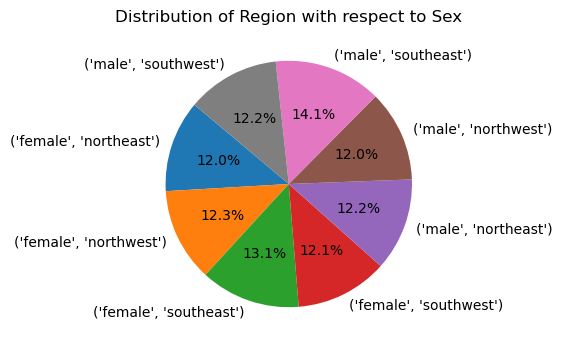

In [13]:
counts=df.groupby(['sex','region']).size()
plt.figure(figsize=(6, 4))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Region with respect to Sex')
plt.show()


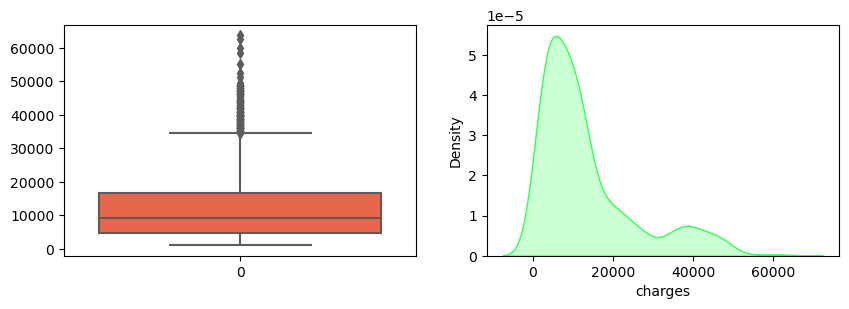

In [14]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.boxplot(df['charges'],color='#FF5733')
plt.subplot(1,2,2)
sns.kdeplot(df['charges'], shade=True,color='#33FF57')
plt.show()

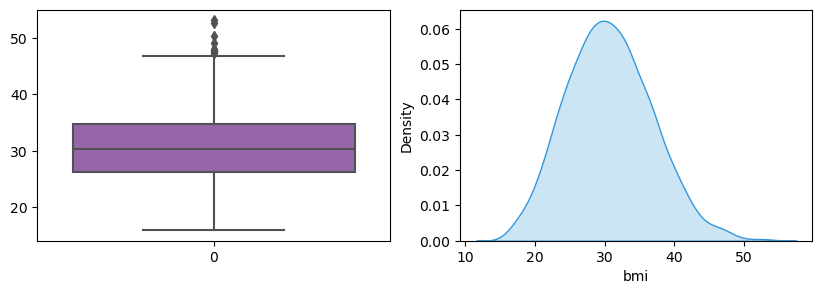

In [24]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.boxplot(df['bmi'],color='#9B59B6')
plt.subplot(1,2,2)
sns.kdeplot(df['bmi'], shade=True,color='#3498DB')
plt.show()

## Feature Engineering

##### The boxplot of df['charges'] shows that there are certain outliers in my data. Hence capping will be done on this column using the IQR method for outlier removal because my data is right skewed

In [16]:
q1= df['charges'].quantile(0.25)
q3= df['charges'].quantile(0.75)
print('25th percent Quantile value:',q1)
print('75th percent Quantile value:',q3)

25th percent Quantile value: 4746.344
75th percent Quantile value: 16657.71745


In [17]:
IQR= q3-q1
print('IQR:', IQR)

IQR: 11911.37345


In [18]:
upper_limit= q3+1.5*IQR
lower_limit= q1-1.5*IQR
print('upper_limit:', upper_limit)
print('lower_limit:', lower_limit)


upper_limit: 34524.777625
lower_limit: -13120.716174999998


In [19]:
new_df_cap = df.copy()
new_df_cap['charges']=np.where(new_df_cap['charges']>upper_limit,
                              upper_limit,
                              np.where(new_df_cap['charges']<lower_limit,
                                      lower_limit,
                                      new_df_cap['charges']))



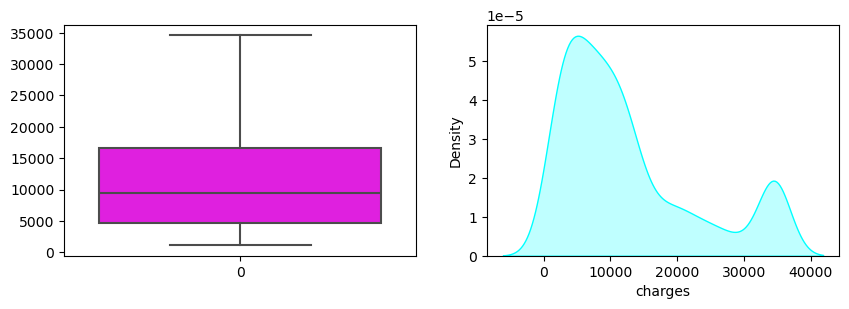

In [16]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.boxplot(new_df_cap['charges'],color='#FF00FF')
plt.subplot(1,2,2)
sns.kdeplot(new_df_cap['charges'], shade=True, color='#00FFFF')
plt.show()

##### Splitting my data into training and testing sets

In [25]:
new_df_cap['bmi']= df['bmi']
new_df_cap.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [26]:
X = new_df_cap.iloc[:, 0:6]
y= new_df_cap.iloc[:,-1]


In [27]:
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42,test_size=0.2)

In [23]:
X_train.shape

(1069, 6)

In [144]:
X_test.shape

(268, 6)

##### Applying One-Hot-Encoding on my categorical variables


In [28]:
ohe= OneHotEncoder(drop='first',sparse=False,dtype=np.int32)

In [29]:
new_Xtrain=ohe.fit_transform(X_train[['sex','smoker','region']])
new_Xtest=ohe.fit_transform(X_test[['sex','smoker','region']])
new_Xtrain



array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0]])

In [31]:
new_Xtrain.shape

(1069, 5)

In [47]:
X_train[['age','bmi','children']].values

array([[23.   , 24.51 ,  0.   ],
       [21.   , 25.745,  2.   ],
       [52.   , 37.525,  2.   ],
       ...,
       [20.   , 22.   ,  1.   ],
       [38.   , 28.   ,  3.   ],
       [35.   , 35.86 ,  2.   ]])

In [34]:
X_train[['age','bmi','children']].shape

(1069, 3)

In [49]:
X_train_transformed= np.concatenate((X_train[['age','bmi','children']].values,new_Xtrain),axis=1)
X_train_transformed

array([[23.   , 24.51 ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [21.   , 25.745,  2.   , ...,  0.   ,  0.   ,  0.   ],
       [52.   , 37.525,  2.   , ...,  1.   ,  0.   ,  0.   ],
       ...,
       [20.   , 22.   ,  1.   , ...,  0.   ,  0.   ,  1.   ],
       [38.   , 28.   ,  3.   , ...,  0.   ,  0.   ,  1.   ],
       [35.   , 35.86 ,  2.   , ...,  0.   ,  1.   ,  0.   ]])

In [50]:
X_train_transformed.shape

(1069, 8)

In [51]:
X_test_transformed= np.concatenate((X_test[['age','bmi','children']].values,new_Xtest),axis=1)
X_test_transformed

array([[49.   , 22.515,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [29.   , 25.6  ,  4.   , ...,  0.   ,  0.   ,  1.   ],
       [51.   , 36.385,  3.   , ...,  1.   ,  0.   ,  0.   ],
       ...,
       [22.   , 34.58 ,  2.   , ...,  0.   ,  0.   ,  0.   ],
       [61.   , 36.3  ,  1.   , ...,  0.   ,  0.   ,  1.   ],
       [47.   , 24.32 ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [52]:
X_test_transformed.shape

(268, 8)

## Applying Linear Regression Model

In [56]:
lr= LinearRegression()

In [57]:
lr.fit(X_train_transformed,y_train)

LinearRegression()

In [63]:
y_pred=lr.predict(X_test_transformed)

In [67]:
y_pred

array([ 8659.21328937,  6388.20379389, 13452.39037287, 27981.31697044,
        8250.93946101, 12093.59512912, 26682.98531637,  2685.27676907,
       10106.96341692, 11130.69239134, 11017.89276712, 29784.06173142,
       27359.83351233, 15647.51869251, 10017.45547546,  9486.37139932,
        4345.75686993, 27881.20386477,  4157.97836383,  5673.1137966 ,
        3925.06559318, 27052.96599801, 13425.52000149, 27251.64156533,
       27504.2814952 ,  5678.01297238, 31020.99994607, 32456.64432539,
       11119.32256569, 13104.62693735,  6684.94747079, 11759.10827203,
        1641.45518201, 11900.43182367, 34291.26469066, 11768.89933315,
        5256.28511755,  5222.26304965, 28156.10303219,  9150.17096963,
        6544.68336089, 27594.9280406 , 30542.31878999, 11670.9214544 ,
        8341.77014527,  4350.98620205,  5750.72474209,  9054.40564352,
        5130.53519828,  8744.46814522,  6644.92104655, 10741.25773417,
       28252.09908062,  3773.36367054, 10338.01671109,  9510.25996587,
      

In [71]:
y_test.values

array([ 8688.85885 ,  5708.867   , 11436.73815 , 34524.777625,
        4463.2051  ,  9304.7019  , 34524.777625,  2150.469   ,
        7345.7266  , 10264.4421  , 13415.0381  , 24393.6224  ,
       34524.777625, 13063.883   , 24915.04626 ,  8027.968   ,
        1980.07    , 34524.777625,  3484.331   ,  3947.4131  ,
        1880.07    , 20773.62775 ,  9800.8882  , 21082.16    ,
       34524.777625,  3579.8287  , 34524.777625, 34524.777625,
        9778.3472  , 10736.87075 ,  4347.02335 ,  9048.0273  ,
        1711.0268  , 12333.828   , 34524.777625,  9872.701   ,
        4687.797   ,  5693.4305  , 21195.818   ,  8233.0975  ,
        2755.02095 , 19798.05455 , 34524.777625,  9964.06    ,
        9193.8385  ,  3161.454   ,  2217.6012  ,  7337.748   ,
        4133.64165 ,  6338.0756  ,  4349.462   ,  5757.41345 ,
       21771.3423  ,  1391.5287  ,  7160.094   ,  7731.4271  ,
        9957.7216  ,  3594.17085 , 34524.777625,  7256.7231  ,
       10977.2063  ,  5245.2269  , 11187.6567  ,  1708.

### Checking the accuracy of our model 

In [72]:
print('mean absolute error:', mean_absolute_error(y_test,y_pred))

mean absolute error: 3148.8373898312548


In [75]:
print('mean squared error:', mean_squared_error(y_test,y_pred))

mean squared error: 20913453.80424189


In [76]:
print(' root mean squared error:', np.sqrt(mean_squared_error(y_test,y_pred)))

 root mean squared error: 4573.122981534816


In [82]:
print('r2_score:', r2_score(y_test,y_pred))
r2= r2_score(y_test,y_pred)

r2_score: 0.8210286113815228


In [89]:
Adjusted_r2_score= 1-((1-r2)*(268-1)/(268-1-6))
print('Adjusted r2_score:',Adjusted_r2_score)

Adjusted r2_score: 0.8169143265856957
